## Changes in the DLinear 

shuffle_flag = True --> False for tersting 

shuffle_flag = True --> False for training 


model_name=DLinear --> Linear 

In dataloader: Dataset_ETT_hour(scale=True-->False)

AR: Scale->Predict->Unscale->MSE: 
Linear: Scale->Predict->Unscale->MSE: 

AR: Scale->Predict->MSE: 
Linear: Scale->Predict->MSE: 0.375

AR: No scaling-> Predict -> MSE 
Linear: No Scaling -> Predict-> MSE 

Make sure inputs are same. 

In [1]:
seq_len = 336 
border1s = [0, 12 * 30 * 24 - seq_len, 12 * 30 * 24 + 4 * 30 * 24 - seq_len]
border2s = [12 * 30 * 24, 12 * 30 * 24 + 4 * 30 * 24, 12 * 30 * 24 + 8 * 30 * 24]

In [2]:
border1s, border2s

([0, 8304, 11184], [8640, 11520, 14400])

In [44]:
import torch 
import neuralprophet
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed 
set_log_level("ERROR", "INFO")

import numpy as np
set_random_seed(0)
import pandas as pd
from sklearn.preprocessing import StandardScaler

import copy 

def MSE(g_truth, measured):
    n=len(g_truth)
    diff=g_truth-measured
    return np.sum(np.square(diff)) / n 
    
    

from sklearn.metrics import mean_absolute_percentage_error
def MAPE(g_truth, measured):
    return (mean_absolute_percentage_error(g_truth,measured))

def wMAPE(g_truth, measured):
    nR = np.sum( np.absolute (g_truth-measured ))
    dR = np.sum( np.absolute (g_truth) )
    return (nR/dR)


def getPercentagedataset(N,n=96):
    print ("N, n", N,n)
    return ((n)/N)

def readDataset(csvFilename=""):
    df = pd.read_csv(csvFilename)
    print ("shape of dataset: ", df.shape)
    return df 

def ScaleDataset(df, date, numericalCols ):
    df = copy.deepcopy(df)
    date = copy.deepcopy(date)
    numericalCols = copy.deepcopy(numericalCols)
    scaler = StandardScaler()
    # Fit the scaler to the data
    scaler.fit(df)
    # Transform the data using the scaler
    df = scaler.transform(df)
    df = pd.DataFrame(df)
    #df["date"] = date
    #numericalCols.append("date")
    numericalCols.insert(0,"date")
    print ("date: ", date.shape, "df: ",df.shape)

    df.insert(0,'date', date.tolist())
    print ("columns: " , df.columns)
    #print (df[1:2])
    df = df.set_axis(numericalCols, axis=1, inplace=False)

    return df



def prepareDataFrame(df):
    nrows_=df.shape[0]
    regions = list(df)[1:]
    df_global = pd.DataFrame()
    for col in regions:
        print (col)
        aux = df[["date", col]].copy(deep=True)  # select column associated with region
        aux = aux.iloc[:nrows_, :].copy(deep=True)  # selects data up to 26301 row (2004 to 2007 time stamps)
        aux = aux.rename(columns={col: "y"})  # rename column of data to 'y' which is compatible with Neural Prophet
        aux["ID"] = col
        df_global = pd.concat((df_global, aux))


    df_global.rename({"date":"ds"},
                 inplace=True,
                axis=1)
    return df_global

def train_test_split(df_global, nhorizion=96, valid_p_=-1):
    print ("percentage test: ", valid_p_)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    df_train, df_test = m.split_df(df_global, valid_p=valid_p_, local_split=True)
    print ("train, test shape: ",df_train.shape, df_test.shape)
    return (df_train, df_test)

def training(df_train, df_test, col=""):
    print ("initialising  neuralprophet model with n_lag=336, global trend and seasonal effect")
    #m = NeuralProphet(trend_global_local="global", season_global_local="global", n_lags=336)
    m = NeuralProphet(growth='off',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  n_lags=336,
                  learning_rate=0.005,
                  epochs=10,
                  batch_size=32,
                      normalize="off",
                      loss_func='MSE'
                     ) ## only AR-net 
    metrics = m.fit(df_train, freq='auto')

    ## this function returun 
    #### mse_, forecast_ when column with name OT is present, forecast for all the columns
    
    def forecasting(m,df_test):
        future = m.make_future_dataframe(df_test, n_historic_predictions=True)
        print ("forecasting....")
        forecast = m.predict(future)
        forecast_=forecast[(forecast.ID=="OT")].dropna()
        forecast = forecast.dropna()
        mse_=MSE(forecast.y.to_numpy(), forecast.yhat1.to_numpy()) #, MAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy()), wMAPE(forecast_.y.to_numpy(), forecast_.yhat1.to_numpy())
        return (mse_,forecast_,forecast)
    #-----
    mse_list=[]
    if  type(df_test) == list:
        print ("list")
        for idf in df_test:
            mse_ = forecasting(m,idf)
            mse_list.append(mse_)
        return (mse_list)    
    elif type(df_test) == pd.DataFrame:
        print ("dataframe")
        mse_ = forecasting(m,df_test)
        return (mse_)
    else: 
        print ("not a valid format for forecasting ")

    

def forecast( dataset_ = "ETTh1.csv",nhorizion=96,datasetname="divvy"):
    df=readDataset(dataset_)
    if datasetname=="divvy":
        hourly_checkout = [ic for ic in df.columns if "_checkout" in ic]
        hourly_checkout.insert(0,"checkouthour")
        hourly_checkout=hourly_checkout[:7]
        df = df[hourly_checkout]
        df.rename(columns={"checkouthour":"date"},inplace=True)

    numericalCols = list(df)[1:] 
    #df = ScaleDataset(df[numericalCols],df.date, numericalCols)

    ####valid_p_ = getPercentagedataset(len(df),nhorizion)
    df = prepareDataFrame(df)
    df_train,df_test = train_test_split(df, valid_p_=nhorizion) # valid_p can be kept as integer as well, note that test dataset will also have the past look up dataset, i.e. 338 in this case, so the total dataset size would be past look up + forecast horizion ; 338 + 96 
    mse_ = training(df_train,df_test)
    return mse_




In [45]:
mse_divvy = forecast(dataset_="DivvyBikes/df2021-8-9-10.csv",nhorizion=96)

shape of dataset:  (2208, 1589)
13001_checkout
13006_checkout
13008_checkout
13011_checkout
13016_checkout
13017_checkout
percentage test:  96
train, test shape:  (12672, 3) (2592, 3)
initialising  neuralprophet model with n_lag=336, global trend and seasonal effect


Training: 0it [00:00, ?it/s]

dataframe
forecasting....


Predicting: 333it [00:00, ?it/s]

Predicting: 333it [00:00, ?it/s]

Predicting: 333it [00:00, ?it/s]

Predicting: 333it [00:00, ?it/s]

Predicting: 333it [00:00, ?it/s]

Predicting: 333it [00:00, ?it/s]

In [49]:
print (f'MSE for forecast horizion 96 is {mse_divvy[0]}')

MSE for forecast horizion 96 is 7.81001760832205


<AxesSubplot:>

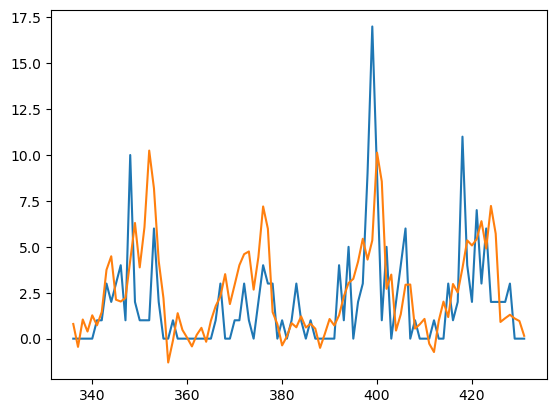

In [47]:
mse_divvy[2] [mse_divvy[2].ID == "13001_checkout"].y.plot()
mse_divvy[2] [mse_divvy[2].ID == "13001_checkout"].yhat1.plot()


In [48]:
mse_divvy[2] [mse_divvy[2].ID == "13001_checkout"]

,ds,y,ID,yhat1,ar1,trend
336,2021-10-28 00:00:00,0.0,13001_checkout,0.799346,0.817807,-0.018461
337,2021-10-28 01:00:00,0.0,13001_checkout,-0.449058,-0.430597,-0.018461
338,2021-10-28 02:00:00,0.0,13001_checkout,1.042615,1.061076,-0.018461
339,2021-10-28 03:00:00,0.0,13001_checkout,0.388907,0.407368,-0.018461
340,2021-10-28 04:00:00,0.0,13001_checkout,1.270881,1.289342,-0.018461
...,...,...,...,...,...,...
427,2021-10-31 19:00:00,2.0,13001_checkout,1.113781,1.132241,-0.018461
428,2021-10-31 20:00:00,3.0,13001_checkout,1.300919,1.319380,-0.018461
429,2021-10-31 21:00:00,0.0,13001_checkout,1.098320,1.116780,-0.018461
430,2021-10-31 22:00:00,0.0,13001_checkout,0.958556,0.977017,-0.018461


In [24]:
df_ = mse_divvy[2].dropna()
df_.yhat1 =  df_.yhat1.astype(int).clip(0)
df_.y =  df_.y#.astype(int).clip(0)


WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_39563/566071644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.yhat1 =  df_.yhat1.astype(int).clip(0)

WARNING - (py.warnings._showwarnmsg) - /var/folders/y_/ckryxn657xd1sjqy61rgk5q80000gn/T/ipykernel_39563/566071644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.y =  df_.y#.astype(int).clip(0)



In [4]:
df_.ID.unique().shape

(199,)

In [5]:
df_

,ds,y,ID,yhat1,ar1,trend
336,2021-10-18 00:00:00,0.0,13001_checkout,0,-0.299385,0.030328
337,2021-10-18 01:00:00,0.0,13001_checkout,0,-0.305675,0.030328
338,2021-10-18 02:00:00,0.0,13001_checkout,0,-0.279031,0.030328
339,2021-10-18 03:00:00,0.0,13001_checkout,0,-0.480228,0.030328
340,2021-10-18 04:00:00,0.0,13001_checkout,0,-0.596407,0.030328
...,...,...,...,...,...,...
133921,2021-10-31 19:00:00,0.0,16915_checkout,0,-0.031734,0.030328
133922,2021-10-31 20:00:00,0.0,16915_checkout,0,0.002314,0.030328
133923,2021-10-31 21:00:00,0.0,16915_checkout,0,0.024343,0.030328
133924,2021-10-31 22:00:00,0.0,16915_checkout,0,0.014334,0.030328


In [7]:
MAPE(df_.y, df_.yhat1)

645594077954448.0

In [9]:
df_10=df_[df_.y>-1]

In [10]:
df_10.ID.unique().shape

(199,)

In [11]:
MAPE(df_10.y, df_10.yhat1)   ## with trend and seasonality 0.388, 

645594077954448.0

In [12]:
def mymape(y_true, y_pred):
    # Calculate MAPE
    n = len(y_true)
    mape = (1 / n) * np.sum(np.abs((y_true - y_pred) / y_true)) #* 100
    return mape


In [13]:
mape_=[]
for iid in df_10.ID.unique():
    df_iid = df_10[df_10.ID==iid]
    #mape_.append(MAPE(df_iid.y,df_iid.yhat1))
    mape_.append(MAPE(np.array([df_iid.y.sum()]), np.array([df_iid.yhat1.sum()])))

<AxesSubplot:>

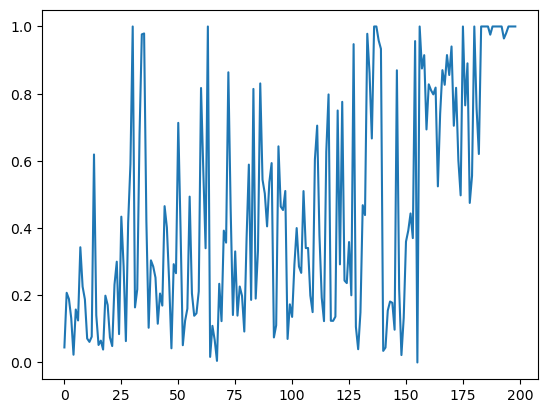

In [14]:
pd.Series(mape_).plot()

<AxesSubplot:>

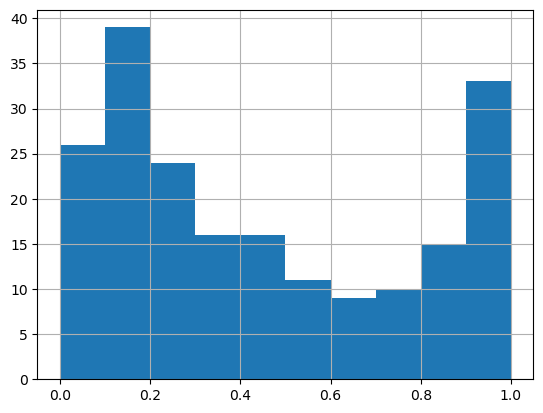

In [15]:
pd.Series(mape_).hist()

<AxesSubplot:>

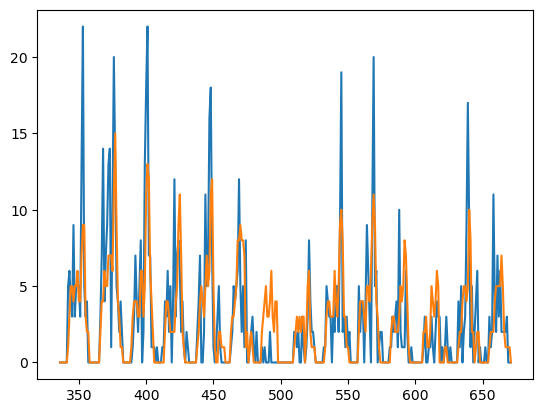

In [16]:
df_10[df_10.ID=="13001_checkout"].y.plot()
df_10[df_10.ID=="13001_checkout"].yhat1.plot()


In [17]:
df_10[df_10.ID=="13001_checkout"].y

336    0.0
337    0.0
338    0.0
339    0.0
340    0.0
      ... 
667    2.0
668    3.0
669    0.0
670    0.0
671    0.0
Name: y, Length: 336, dtype: float64